In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import errno
import utils

import CGDs
import importlib
importlib.reload(CGDs)


from pyDOE import lhs
from torch import from_numpy

import torch
import torch.cuda
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad

# Manage device

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


In [3]:
# utils.printMemory()

# Data Sampling

In [4]:
samples = {"pde": 50000, "bc":5000, "fc":5000}

K = 40.0
r = 0.05
sigma = 0.25
T = 1.0
S_range = [0.0, 130.0]
t_range = [0.0, T]
gs = lambda x: np.fmax(x-K, 0.0)

# Build Neural Network

In [5]:
import networks
# Create the model
PINNGACGD = networks.FeedforwardNeuralNetwork(2, 50, 1, 3)
PINNGACGD.to(device)
print(PINNGACGD)

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


In [6]:
D_GACGD = networks.Discriminator(2, 25, 1)
D_GACGD.to(device)
D_GACGD.load_state_dict(D_GACGD.state_dict()) # copy weights and stuff
print(D_GACGD)

Discriminator(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)


# Network Trainig

### Hyperparameters

In [7]:
max_iter = 30000

# Define loss function and optimizer
tol = 1e-7
atol = 1e-20
g_iter = 1000
lr = 0.0002
track_cond = lambda x, y:  True

# optimizer = CGDs.GACGD(x_params=D_GACGD.parameters(), y_params = PINNGACGD.parameters(), max_iter = g_iter,
#             lr_x=lr, lr_y=lr, tol=tol, atol = atol, eps=1e-8, beta=0.99, track_cond = track_cond)
optimizer = CGDs.ACGD(max_params=D_GACGD.parameters(), min_params = PINNGACGD.parameters(),
            lr_min=lr, lr_max=lr, beta=0.99, eps=1e-8, tol=tol, collect_info=True)
# optimizer = optimizer = CGDs.BCGD(max_params=D_GACGD.parameters(), min_params=PINNGACGD.parameters(), device = device,
#                  lr_max=lr, lr_min=lr, tol=1e-10, collect_info=True)
lossFunction = nn.MSELoss()
lossfunction2 = nn.L1Loss()

### Training

In [8]:
start_time=time.time()
loss_hist = []

for epoch in range(max_iter):
    
    optimizer.zero_grad() # zeroes the gradient buffers of all parameters
    
    # sampling
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, 
                       r, 
                       sigma, 
                       T, 
                       S_range[-1], 
                       S_range, 
                       t_range, 
                       gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    
    # normal loss
    # print(n_st_train)
    # print(PINNBCGD.output.weight.dtype)
    v1_hat = PINNGACGD(n_st_train)
    
    grads = tgrad.grad(v1_hat, n_st_train, grad_outputs=torch.ones(v1_hat.shape).cuda(), 
                       retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat)
    
    # print('ffffffffffffffffffffffffffffffff')
    loss1 = D_GACGD(n_st_train) * (dVdt + 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat)
    
    
    # boundary condition loss
    bc_hat = PINNGACGD(bc_st_train)
    # print(bc_v_train)
    # print('111111111111111111111')
    # print(bc_hat)
    bc_loss = lossFunction(bc_v_train, bc_hat)
    
    loss2 = D_GACGD(bc_st_train) * (bc_hat - bc_v_train)
    
    
    # Backpropagation and Update
    combined_loss = (loss1.mean() + loss2.mean())
    pinn_loss = pde_loss.mean() + bc_loss.mean()
    # combined_loss.backward()
    
    # print('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz')
    # optimizer.step(-combined_loss, combined_loss, 0)
    optimizer.step(combined_loss)
    # print('pppppppppppppppppppppppppppp')
    
    loss_hist.append(pinn_loss.item())
    if epoch % 50 == 0:
        print(f'{epoch}/{max_iter} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, \
                  mse loss: {pinn_loss.item():5f}, combined loss: {combined_loss.item():.5f}')
        pass
    
    # print(epoch)
        
end_time = time.time()
print('run time:', end_time - start_time)
print('finish')

0/30000 PDE Loss: 0.00042, BC Loss: 3329.17798,                   mse loss: 3329.178467, combined loss: -10.30507
50/30000 PDE Loss: 0.00649, BC Loss: 1105.03003,                   mse loss: 1105.036499, combined loss: 157.12521
100/30000 PDE Loss: 0.00104, BC Loss: 83.23558,                   mse loss: 83.236618, combined loss: -0.87450
150/30000 PDE Loss: 0.02040, BC Loss: 75.00037,                   mse loss: 75.020775, combined loss: 1.04157
200/30000 PDE Loss: 0.05874, BC Loss: 73.84547,                   mse loss: 73.904221, combined loss: 1.47426
250/30000 PDE Loss: 0.12903, BC Loss: 72.59559,                   mse loss: 72.724617, combined loss: 1.93964
300/30000 PDE Loss: 0.43703, BC Loss: 69.97563,                   mse loss: 70.412666, combined loss: 2.51815
350/30000 PDE Loss: 1.75987, BC Loss: 64.52721,                   mse loss: 66.287086, combined loss: 3.84779
400/30000 PDE Loss: 5.29682, BC Loss: 58.42648,                   mse loss: 63.723301, combined loss: 5.04069


Text(0.5, 1.0, 'CPINN-GACGD')

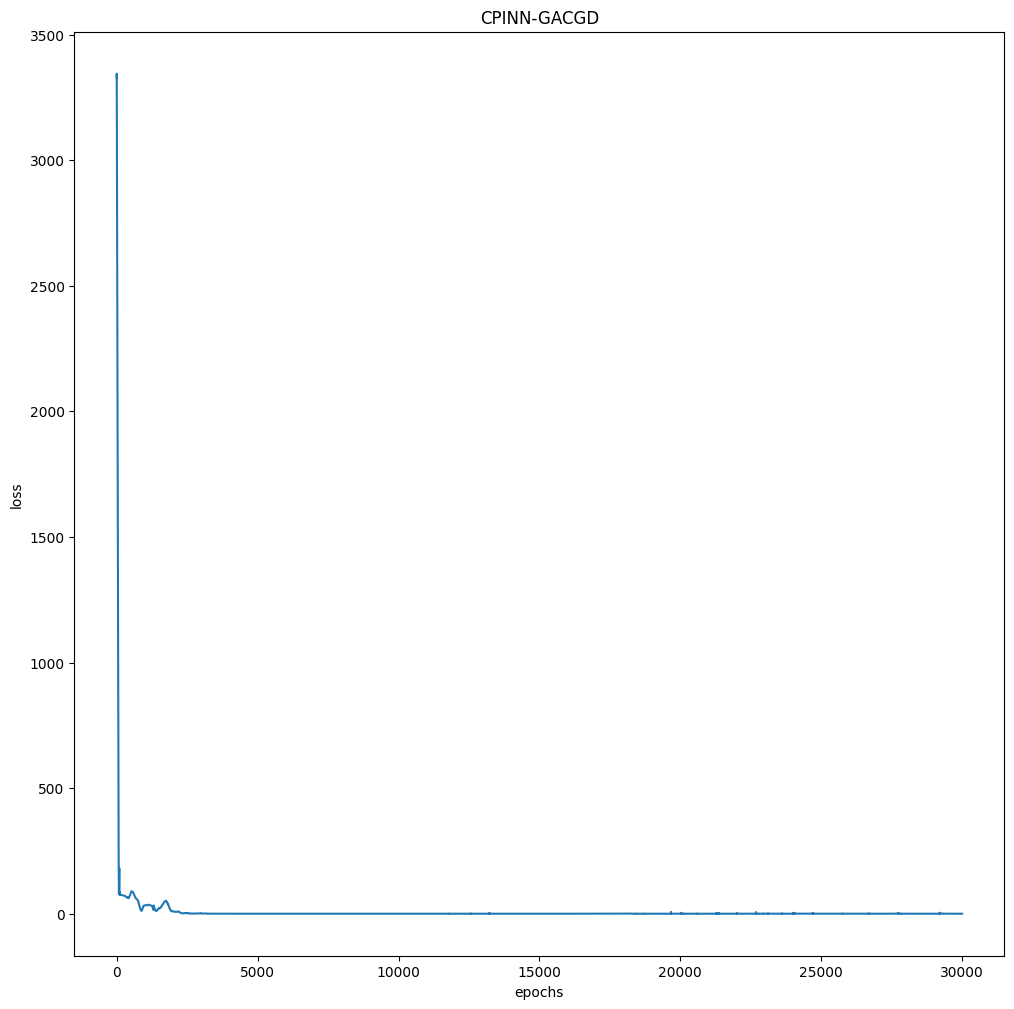

In [9]:
fig = plt.figure(figsize=(12,12))
plt.plot(range(30000), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('CPINN-GACGD')